# Training AIDA in Google Colab tutorial

In order to train an agent on GPU, go to Runtime->Change runtime type->Hardware accelerator->GPU

## Import files

Let open the access to **Google Drive** and install/import all the necessary libraries:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install path.py;
from path import Path
import math
import torch
import sys
import os
import argparse
import time
import gym
import numpy as np
import itertools
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F
from torch.optim import Adam
import random
from collections import namedtuple
import matplotlib.pyplot as plt


In [3]:
!pip install pybullet

    100% |████████████████████████████████| 39.9MB 1.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/3d/c6/80e5ee17f58abd5e4d7b8ef9e6c5b101ae8863de15cb989409
Successfully built pybullet


Now we have to upload ***aida_gym*** to **Google Drive**. You may either do it yourself or just run the next cell.


In [5]:
!git clone https://github.com/unsupervisedai/aida_gym /content/gdrive/My\ Drive/aida_gym

fatal: destination path '/content/gdrive/My Drive/aida_gym' already exists and is not an empty directory.


Now you should see  ***aida_gym*** in the output of the next cell:

In [ ]:
!cd /content/gdrive/My\ Drive/; ls

In [ ]:
sys.path.append('/content/gdrive/My Drive/aida_gym') 

And we are able to import packages from ***aida_gym***. If it doesn't work, go to ***github*** and upload another version of ***aida_gym_env.py***. Then wait for several minutes and try to import again.

In [ ]:
import aida_env.aida_gym_env as e
import pybullet as p

## Soft Actor-Critic Algorithm

In [ ]:
def create_log_gaussian(mean, log_std, t):
    quadratic = -((0.5 * (t - mean) / (log_std.exp())).pow(2))
    l = mean.shape
    log_z = log_std
    z = l[-1] * math.log(2 * math.pi)
    log_p = quadratic.sum(dim=-1) - log_z.sum(dim=-1) - 0.5 * z
    return log_p

def logsumexp(inputs, dim=None, keepdim=False):
    if dim is None:
        inputs = inputs.view(-1)
        dim = 0
    s, _ = torch.max(inputs, dim=dim, keepdim=True)
    outputs = s + (inputs - s).exp().sum(dim=dim, keepdim=True).log()
    if not keepdim:
        outputs = outputs.squeeze(dim)
    return outputs

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)


In [ ]:
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()

        # Q1 architecture
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        # Q2 architecture
        self.linear4 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state, action):
        xu = torch.cat([state, action], 1)
        
        x1 = F.relu(self.linear1(xu))
        x1 = F.relu(self.linear2(x1))
        x1 = self.linear3(x1)

        x2 = F.relu(self.linear4(xu))
        x2 = F.relu(self.linear5(x2))
        x2 = self.linear6(x2)

        return x1, x2


class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(GaussianPolicy, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        action = torch.tanh(x_t)
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob, torch.tanh(mean)

class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = torch.tanh(self.mean(x))
        return mean


    def sample(self, state):
        mean = self.forward(state)
        noise = self.noise.normal_(0., std=0.1)
        noise = noise.clamp(-0.25, 0.25)
        action = mean + noise
        return action, mean, torch.tensor(0.)

In [ ]:
class SAC(object):
    def __init__(self, num_inputs, action_space, args):

        self.num_inputs = num_inputs
        self.action_space = action_space.shape[0]
        self.gamma = args.gamma
        self.tau = args.tau

        self.policy_type = args.policy
        self.target_update_interval = args.target_update_interval
        self.automatic_entropy_tuning = args.automatic_entropy_tuning

        self.device = torch.device("cuda" if args.cuda else "cpu") 

        self.critic = QNetwork(self.num_inputs, self.action_space, args.hidden_size).to(device=self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=args.lr)

        if self.policy_type == "Gaussian":
            self.alpha = args.alpha
            # Target Entropy = −dim(A) (e.g. , -6 for HalfCheetah-v2) as given in the paper
            if self.automatic_entropy_tuning == True:
                self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(self.device)).item()
                self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
                self.alpha_optim = Adam([self.log_alpha], lr=args.lr)


            self.policy = GaussianPolicy(self.num_inputs, self.action_space, args.hidden_size).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=args.lr)

            self.value = ValueNetwork(self.num_inputs, args.hidden_size).to(self.device)
            self.value_target = ValueNetwork(self.num_inputs, args.hidden_size).to(self.device)
            self.value_optim = Adam(self.value.parameters(), lr=args.lr)
            hard_update(self.value_target, self.value)
        else:
            self.policy = DeterministicPolicy(self.num_inputs, self.action_space, args.hidden_size).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=args.lr)

            self.critic_target = QNetwork(self.num_inputs, self.action_space, args.hidden_size).to(self.device)
            hard_update(self.critic_target, self.critic)



    def select_action(self, state, eval=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        if eval == False:
            self.policy.train()
            action, _, _ = self.policy.sample(state)
        else:
            self.policy.eval()
            _, _, action = self.policy.sample(state)
        action = action.detach().cpu().numpy()
        return action[0]



    def update_parameters(self, state_batch, action_batch, reward_batch, next_state_batch, mask_batch, updates):
        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        qf1, qf2 = self.critic(state_batch, action_batch) # Two Q-functions to mitigate positive bias in the policy improvement step
        pi, log_pi, _ = self.policy.sample(state_batch)

        if self.policy_type == "Gaussian":
            if self.automatic_entropy_tuning:
                alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
                self.alpha_optim.zero_grad()
                alpha_loss.backward()
                self.alpha_optim.step()
                self.alpha = self.log_alpha.exp()
                alpha_logs = torch.tensor(self.alpha) # For TensorboardX logs
            else:
                alpha_loss = torch.tensor(0.).to(self.device)
                alpha_logs = torch.tensor(self.alpha) # For TensorboardX logs

            vf = self.value(state_batch) # separate function approximator for the soft value can stabilize training.
            with torch.no_grad():
                vf_next_target = self.value_target(next_state_batch)
                next_q_value = reward_batch + mask_batch * self.gamma * (vf_next_target)
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_logs = self.alpha  # For TensorboardX logs
            with torch.no_grad():
                next_state_action, _, _, _, _, = self.policy.sample(next_state_batch)
                # Use a target critic network for deterministic policy and eradicate the value value network completely.
                qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
                min_qf_next_target = torch.min(qf1_next_target, qf2_next_target)
                next_q_value = reward_batch + mask_batch * self.gamma * (min_qf_next_target)
        
        
        qf1_loss = F.mse_loss(qf1, next_q_value) # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf2_loss = F.mse_loss(qf2, next_q_value) # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)

        if self.policy_type == "Gaussian":
            vf_target = min_qf_pi - (self.alpha * log_pi)
            value_loss = F.mse_loss(vf, vf_target.detach()) # JV = 𝔼st~D[0.5(V(st) - (𝔼at~π[Qmin(st,at) - α * log π(at|st)]))^2]

        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean() # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]

        # Regularization Loss
        # mean_loss = 0.001 * mean.pow(2).mean()
        # std_loss = 0.001 * log_std.pow(2).mean()

        # policy_loss += mean_loss + std_loss

        self.critic_optim.zero_grad()
        qf1_loss.backward()
        self.critic_optim.step()

        self.critic_optim.zero_grad()
        qf2_loss.backward()
        self.critic_optim.step()

        if self.policy_type == "Gaussian":
            self.value_optim.zero_grad()
            value_loss.backward()
            self.value_optim.step()
        else:
            value_loss = torch.tensor(0.).to(self.device)

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()
        
        
        """
        We update the target weights to match the current value function weights periodically
        Update target parameter after every n(args.target_update_interval) updates
        """
        if updates % self.target_update_interval == 0 and self.policy_type == "Deterministic":
            soft_update(self.critic_target, self.critic, self.tau)

        elif updates % self.target_update_interval == 0 and self.policy_type == "Gaussian":
            soft_update(self.value_target, self.value, self.tau)
        return value_loss.item(), qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_logs.item()

    # Save model parameters
    def save_model(self, env_name, suffix="", actor_path=None, critic_path=None, value_path=None):
        if not os.path.exists('models/'):
            os.makedirs('models/')

        if actor_path is None:
            actor_path = "models/sac_actor_{}_{}".format(env_name, suffix)
        if critic_path is None:
            critic_path = "models/sac_critic_{}_{}".format(env_name, suffix)
        if value_path is None:
            value_path = "models/sac_value_{}_{}".format(env_name, suffix)
        print('Saving models to {}, {} and {}'.format(actor_path, critic_path, value_path))
        torch.save(self.value.state_dict(), value_path)
        torch.save(self.policy.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)
    
    # Load model parameters
    def load_model(self, actor_path, critic_path, value_path):
        print('Loading models from {}, {} and {}'.format(actor_path, critic_path, value_path))
        if actor_path is not None:
            self.policy.load_state_dict(torch.load(actor_path))
        if critic_path is not None:
            self.critic.load_state_dict(torch.load(critic_path))
        if value_path is not None:
            self.value.load_state_dict(torch.load(value_path))


In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    def save(self, path):
        np.save(path/'ReplayMemory_'+str(self.position)+'.npy', memory.buffer)
        
    def load(self, path, position):
        self.buffer = list(np.load(path/'ReplayMemory_'+str(position)+'.npy'))
        self.position = position
        
        
    def __len__(self):
        return len(self.buffer)

In [ ]:
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        action = (action + 1) / 2  # [-1, 1] => [0, 1]
        action *= (self.action_space.high - self.action_space.low)
        action += self.action_space.low
        return action

    def _reverse_action(self, action):
        action -= self.action_space.low
        action /= (self.action_space.high - self.action_space.low)
        action = action * 2 - 1
        return action

In [17]:
parser = argparse.ArgumentParser(description='PyTorch REINFORCE example')
parser.add_argument('--env-name', default="HalfCheetah-v2",
                    help='name of the environment to run')
parser.add_argument('--policy', default="Gaussian",
                    help='algorithm to use: Gaussian | Deterministic')
parser.add_argument('--eval', type=bool, default=True,
                    help='Evaluates a policy a policy every 10 episode (default:True)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor for reward (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.005, metavar='G',
                    help='target smoothing coefficient(τ) (default: 0.005)')
parser.add_argument('--lr', type=float, default=0.0003, metavar='G',
                    help='learning rate (default: 0.0003)')
parser.add_argument('--alpha', type=float, default=0.2, metavar='G',
                    help='Temperature parameter α determines the relative importance of the entropy term against the reward (default: 0.2)')
parser.add_argument('--automatic_entropy_tuning', type=bool, default=False, metavar='G',
                    help='Temperature parameter α automaically adjusted.')
parser.add_argument('--seed', type=int, default=456, metavar='N',
                    help='random seed (default: 456)')
parser.add_argument('--batch_size', type=int, default=256, metavar='N',
                    help='batch size (default: 256)')
parser.add_argument('--num_steps', type=int, default=1000001, metavar='N',
                    help='maximum number of steps (default: 1000000)')
parser.add_argument('--hidden_size', type=int, default=256, metavar='N',
                    help='hidden size (default: 256)')
parser.add_argument('--updates_per_step', type=int, default=1, metavar='N',
                    help='model updates per simulator step (default: 1)')
parser.add_argument('--start_steps', type=int, default=10000, metavar='N',
                    help='Steps sampling random actions (default: 10000)')
parser.add_argument('--target_update_interval', type=int, default=1, metavar='N',
                    help='Value target update per no. of updates per step (default: 1)')
parser.add_argument('--replay_size', type=int, default=1000000, metavar='N',
                    help='size of replay buffer (default: 10000000)')
parser.add_argument('--cuda', action="store_true",
                    help='run on CUDA (default: False)')

_StoreTrueAction(option_strings=['--cuda'], dest='cuda', nargs=0, const=True, default=False, type=None, choices=None, help='run on CUDA (default: False)', metavar=None)

## Training of an Aida agent

We will pass these arguments to initialize an agent instance


In [ ]:
global args
args = parser.parse_args(args=['--env-name', 'Ant-v2', '--alpha', '0.2', '--cuda'])

Define the path to save the trained network and the agent's memory. 

In [ ]:
model_path = Path(root_dir+"sac_2_saved_models");

Let define our environment. Change weights to modify the reward.

In [24]:
env = NormalizedActions(e.AidaBulletEnv(
               distance_weight=350,
               energy_weight=0.5,
               shake_weight=40,
               drift_weight=40,
               height_weight=10,
               back_weight=5,
               render=False,
               on_rack=False))

torch.manual_seed(args.seed)
np.random.seed(args.seed)
env.seed(args.seed)

urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
/content/gdrive/My Drive/aida_gym/aida_env/urdf/plane.urdf
/usr/local/lib/python3.6/dist-packages/pybullet_data/plane.urdf
0.01 1.0


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Could not seed environment <AidaBulletEnv instance>
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Let define our agent. 

In [ ]:
agent = SAC(env.observation_space.shape[0], env.action_space, args)

Check that training will be on GPU. The device type should be ***cuda***.

In [27]:
agent.device

device(type='cuda')

In [ ]:
memory = ReplayMemory(args.replay_size)

Imports to save videos of the best results:

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import clear_output

In [ ]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

If you have a pretrained model, you could load it like this:

In [40]:
position = 900007#look on the memory .npy file in your folder to define correctly this position number

agent.load_model(actor_path=model_path/"sac_actor_aida2_br_",critic_path=model_path/"sac_critic_aida2_br_",value_path=model_path/"sac_value_aida2_br_")
memory.load(model_path, position); len(memory.buffer)

Loading models from /content/gdrive/My Drive/PSC/sac_2_saved_models/sac_actor_aida2_br_, /content/gdrive/My Drive/PSC/sac_2_saved_models/sac_critic_aida2_br_ and /content/gdrive/My Drive/PSC/sac_2_saved_models/sac_value_aida2_br_


1000000

The most important thing - the training loop!

---

*   It will save your model to tour **model_path** every 100.000 frames (frames are  different from the episodes) An episode is a period of time when robot walks till he falls. 
*   It will also save videos of best results to your **model_path**.
*   You can see the plot with the reward changing history below the cell.
*   Before the training robot will try some random actions for the first ***args.start_steps*** steps (you can change it by commenting the following lines in the loop)








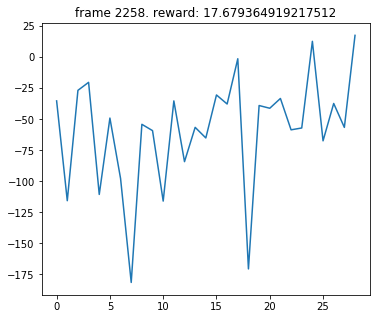

Episode: 29, total numsteps: 2258, reward: 17.68, average reward: -58.81
/content/gdrive/My Drive/aida_gym/aida_env/urdf/plane.urdf
/usr/local/lib/python3.6/dist-packages/pybullet_data/plane.urdf
0.01 1.0


KeyboardInterrupt: ignored

In [45]:
# Training Loop
rewards = []
rews=[]
test_rewards = []
total_numsteps = 0
updates = 0
reward_max = 0
for i_episode in itertools.count(1):
    env.reset();
    state,_ , _, _ = env.step(env.action_space.sample())
    iteration=0
    episode_reward = 0
    while True and iteration<14000:
        if args.start_steps > total_numsteps:#COMMENT THESE LINES TO NOT DO RANDOM ACTIONS BEFORE THE TRAINING
          action = env.action_space.sample() #
        else:                                #
          action = agent.select_action(state)  # Sample action from policy
        if len(memory) > args.batch_size:
            for i in range(args.updates_per_step): # Number of updates per step in environment
                # Sample a batch from memory
                state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(args.batch_size)
                # Update parameters of all the networks
                value_loss, critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(state_batch, action_batch,
                                                                                                reward_batch, next_state_batch, 
                                                                                                mask_batch, updates)
                updates += 1

        next_state, reward, done, _ = env.step(action)  # Step
        mask = float(not done)  # 1 for not done and 0 for done
        
       
        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state
        
        
        if total_numsteps%100000==0:
            memory.save(model_path)
            agent.save_model("aida",actor_path=model_path/"sac_actor_aida2_br_",critic_path=model_path/"sac_critic_aida2_br_",value_path=model_path/"sac_value_aida2_br_")
            print('Model saved')
        total_numsteps += 1
        episode_reward += reward
        iteration+=1
        if done:
            print('done')
            break
    
    if total_numsteps > args.num_steps:
        break
   
    rewards.append(episode_reward)
    plot(total_numsteps, rewards)
    print("Episode: {}, total numsteps: {}, reward: {}, average reward: {}".format(i_episode, total_numsteps, np.round(rewards[-1],2),
                                                                                np.round(np.mean(rewards[-100:]),2)))
    # Save videos of the best results
    if episode_reward > reward_max*1.05:
        reward_max = episode_reward
        env.reset()
        state,_ , _, _ = env.step(env.action_space.sample())
        episode_reward = 0
        i=0
        frames=[]

        while True and i<1000:
            action = agent.select_action(state, eval=True)

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            frames.append(env.render(mode = 'rgb_array'))

            state = next_state
            i+=1
            if done:
                break
        fig, ax = plt.subplots()
        plt.close()
        ax.set_xlim(( -4, 4))
        ax.set_ylim((-2, 2))
        line1, = ax.plot([], [], lw=2)
        line2, = ax.plot([], [], lw=2)

        # initialization function: plot the background of each frame
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
              patch.set_data(frames[i])

        anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)

        rc('animation', html='jshtml')
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        #writer.add_scalar('reward/test', episode_reward, i_episode)
        anim.save(model_path/str(i_episode)+'.mp4', writer=writer)
        test_rewards.append(episode_reward)
        print("----------------------------------------")
        print("Test Episode: {}, reward: {}".format(i_episode, test_rewards[-1]))
        print("----------------------------------------")
    
env.close()